## Setup

In [129]:
import os, sys
dir1 = os.path.abspath(os.path.join(os.path.abspath(''), '..', '..'))
if not dir1 in sys.path: sys.path.append(dir1)

from utils.environment import setup_data_vars
setup_data_vars()

In [130]:
destination = os.path.join(os.environ.get('nnUNet_raw'), os.environ.get('TotalBinary'))
assert os.path.exists(destination), f"Destination folder {destination} does not exist"

gt_path_for_anatomy = lambda x: os.path.join(os.environ.get('nnUNet_raw'), os.environ.get(x), os.environ.get('data_trainingLabels'))
gt_path_for_each_anatomy = dict([(os.environ.get(x), gt_path_for_anatomy(x)) for x in ['Anorectum','Bladder','CTVn','CTVp','Parametrium','Uterus','Vagina']])
assert all([os.path.exists(x) for x in gt_path_for_each_anatomy.values()])

In [131]:
# gt_combined = os.path.join(destination, os.environ.get('data_trainingLabels'))

img = os.path.join(destination, os.environ.get('data_trainingImages'), 'zzAMLART_001_0000.nii.gz')
gt_all = [os.path.join(os.environ.get('nnUNet_raw'), os.environ.get(x), os.environ.get('data_trainingLabels'), 'zzAMLART_001.nii.gz') for x in [
    'Anorectum', 'Bladder', 'CTVn', 'CTVp', 'Parametrium', 'Uterus', 'Vagina', 'TotalBinary'
]]

assert all([os.path.exists(x) for x in gt_all]), f'file not found in gt_all'
assert os.path.exists(img), f'file not found: {img}'

## Get segmented class ids

In [132]:
# read the dataset.json file
import json

dataset_file = os.path.join(destination, 'dataset.json')

with open(dataset_file, 'r') as f:
    dataset = json.load(f)

print(dataset['labels'])

{'background': 0, 'anorectum': [1, 8, 9, 10, 11, 12, 13, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 120, 121, 122, 123, 124, 125, 127], 'bladder': [2, 8, 14, 15, 16, 17, 18, 29, 30, 31, 32, 33, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 126, 127], 'ctvn': [3, 9, 14, 19, 20, 21, 22, 29, 34, 35, 36, 37, 44, 45, 46, 47, 54, 55, 56, 57, 58, 59, 64, 65, 66, 67, 74, 75, 76, 77, 78, 79, 84, 85, 86, 87, 88, 89, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 109, 110, 111, 112, 114, 115, 116, 117, 119, 120, 121, 122, 123, 125, 126, 127], 'ctvp': [4, 10, 15, 19, 23, 24, 25, 30, 34, 38, 39, 40, 44, 48, 49, 50, 54, 55, 56, 60, 61, 62, 64, 68, 69, 70, 74, 75, 

In [133]:
def reverse_lookup_id(id):
    # given a dictinoary of key: anatomy, and value: segmentation ids, reverse the lookup to get the list of anatomies that match the id.
    anatomies = []

    if type(id) == int:
        for k, v in dataset['labels'].items():
            if k == 'background':
                if id == v:
                    anatomies.append('background')
            elif id in v:
                anatomies.append(k)
            
    elif type(id) == list:
        for k, v in dataset['labels'].items():
            if k == 'background' and 0 in id:
                anatomies.append('background')
            elif any([i in v for i in id]):
                anatomies.append(k)
    else:
        raise TypeError('Huh? Whats the type of id? needs to be int or list of ints ', id)

    return anatomies

assert reverse_lookup_id(0) == ['background']
assert reverse_lookup_id(1) == ['anorectum']
assert reverse_lookup_id(100) == ['anorectum', 'bladder', 'ctvn', 'ctvp', 'uterus']
assert reverse_lookup_id([0,1]) == ['background', 'anorectum']

def get_id_from_label(str_id):
    return ['anorectum','bladder','ctvn','ctvp','parametrium','uterus','vagina','totalbinary'][str_id]

assert get_id_from_label(0) == 'anorectum'
assert get_id_from_label(7) == 'totalbinary'

## Read in the image, disaply each slice along an axis

In [134]:
axis = 2

In [135]:
import numpy as np
import SimpleITK as sitk

image_arr = sitk.GetArrayFromImage(sitk.ReadImage(img))
print(gt_all)
gt_arrs = [ (i + 1 if i != 7 else 1) * sitk.GetArrayFromImage(sitk.ReadImage(x)) for i, x in enumerate(gt_all)]

['/vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/nnUNet_raw/Dataset001_Anorectum/labelsTr/zzAMLART_001.nii.gz', '/vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/nnUNet_raw/Dataset002_Bladder/labelsTr/zzAMLART_001.nii.gz', '/vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/nnUNet_raw/Dataset003_CTVn/labelsTr/zzAMLART_001.nii.gz', '/vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/nnUNet_raw/Dataset004_CTVp/labelsTr/zzAMLART_001.nii.gz', '/vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/nnUNet_raw/Dataset005_Parametrium/labelsTr/zzAMLART_001.nii.gz', '/vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/nnUNet_raw/Dataset006_Uterus/labelsTr/zzAMLART_001.nii.gz', '/vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/nnUNet_raw/Dataset007_Vagina/labelsTr/zzAMLART_001.nii.gz', '/vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/nnUNet_raw/Dataset008_TotalBinary/labelsTr/zzAMLART_001.nii.gz']


In [136]:
if axis == 1 or axis == 2:
    image_arr = np.flipud(image_arr)
    gt_arrs = [np.flipud(x) for x in gt_arrs]

In [137]:
def slice_at(slice_id, axis=axis):
    slices = [slice(None)] * 3
    slices[axis] = slice_id
    return tuple(slices)

test_arr = np.random.rand(20, 400, 450)
assert np.array_equal(test_arr[slice_at(10, axis=0)], test_arr[10, :, :])
assert np.array_equal(test_arr[slice_at(200, axis=1)], test_arr[:, 200, :])
assert np.array_equal(test_arr[slice_at(397, axis=2)], test_arr[:, :, 397])

In [138]:
# get the range of indicies where there exists a segmentation along that axis
slice_index = []
for i in range(gt_arrs[-1].shape[axis]):
    slices = slice_at(i)
    my_slice = gt_arrs[-1][slices]
    if np.any(my_slice):
        slice_index.append(i)
print(slice_index)

[183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331]


In [139]:
random_slice = np.random.choice(slice_index)
slice_at(random_slice), axis

((slice(None, None, None), slice(None, None, None), 325), 2)

In [140]:
image_slice = image_arr[slice_at(random_slice)]
gt_slices = [x[slice_at(random_slice)].astype(np.uint8) for x in gt_arrs]

In [141]:
segmentation_ids = list(map(int, np.unique(gt_slices)))
segmentation_ids

[0, 3]

In [142]:
for i,x in enumerate(gt_slices):
    print(reverse_lookup_id(list(np.unique(x))))

['background']
['background']
['background', 'ctvn']
['background']
['background']
['background']
['background']
['background', 'ctvn']


In [143]:
# Find contours in the segmentation map
import cv2

contours, _ = cv2.findContours(gt_slices[-1], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
box_padding = 20

x_min, x_max, y_min, y_max = float('inf'), -float('inf'), float('inf'), -float('inf')

# Loop through contours to find bounding boxes
for contour in contours:
    # Get bounding box coordinates
    x, y, w, h = cv2.boundingRect(contour)
    x_min = min(x_min, x - box_padding)
    y_min = min(y_min, y - box_padding)
    x_max = max(x_max, x + w + box_padding)
    y_max = max(y_max, y + h + box_padding)

# crop the image slice to the region where the gt_slice is non-zero
image_slice_cropped = image_slice # image_slice[y_min:y_max, x_min:x_max]
gt_slices_cropped = gt_slices # [x[y_min:y_max, x_min:x_max] for x in gt_slices]

In [144]:
segmentation_ids

[0, 3]

## Plot the graph

In [145]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

# Generate a custom colormap with vibrant colors for segmentation IDs
colors = plt.cm.tab20(np.linspace(0, 1, len(segmentation_ids) - 1))
# colors = list(colors)
# colors.insert(0, [0,0,0,1])
colors[0] = [0,0,0,1]
# colors = np.array(colors)
cmap = plt.cm.colors.ListedColormap(colors)

[0] anorectum
[0] bladder
[0 3] ctvn
[0] ctvp
[0] parametrium
[0] uterus
[0] vagina
[0 3] totalbinary


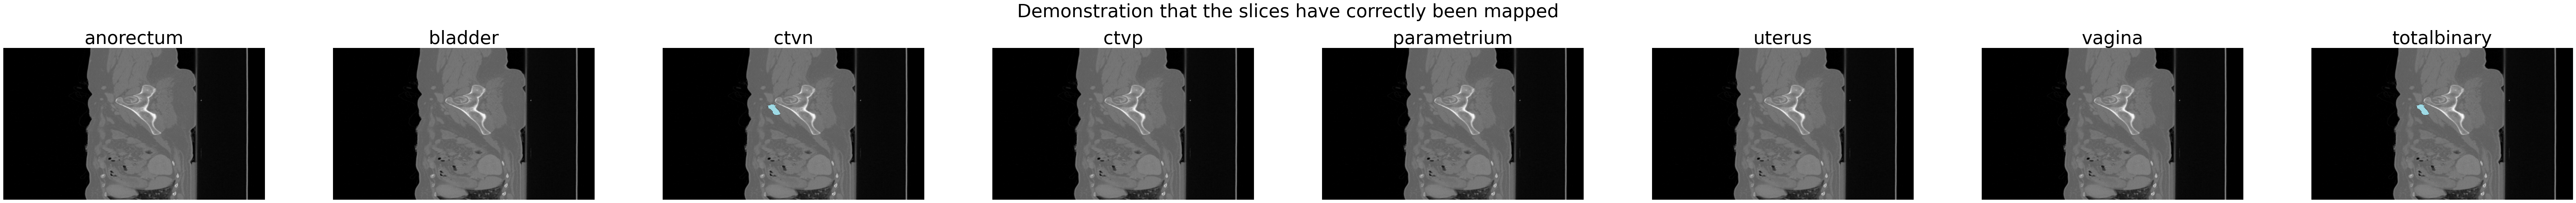

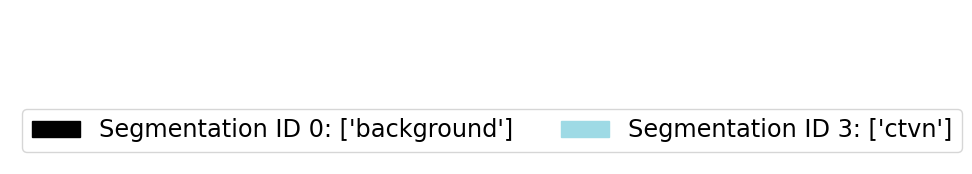

In [146]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

# Assuming you have defined segmentation_ids and gt_all before

# Generate a custom colormap with vibrant colors for segmentation IDs
color_linspace = plt.cm.tab20(np.linspace(0, 1, len(segmentation_ids)))
colors = [[0,0,0] for _ in range(max(segmentation_ids) + 1)]
for i, c in zip(segmentation_ids, color_linspace):
    colors[i] = c[:-1]
colors[0] = [0,0,0]
cmap = plt.cm.colors.ListedColormap(colors)

nrows, ncols = 1, len(gt_all)

# reshape the grid to fit the dimensions of each image
height, width = image_slice_cropped.shape
divisor = max([height, width]) / 10
height, width = height / divisor, width / divisor

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * width, nrows * height))
axes = axes.reshape(nrows, ncols)

for i in range(ncols):
    axes[0, i].imshow(image_slice_cropped, cmap='gray')
    axes[0, i].axis('off')

    print(np.unique(gt_slices_cropped[i]), get_id_from_label(i))

    alpha_mask = np.where(gt_slices_cropped[i] > 0, 1, 0).astype(np.float32)
    axes[0, i].imshow(gt_slices_cropped[i], alpha=alpha_mask, cmap=cmap, vmin=0, vmax=max(segmentation_ids))
    axes[0, i].axis('off')    

    axes[0, i].set_title(get_id_from_label(i), fontsize=40)

plt.suptitle('Demonstration that the slices have correctly been mapped', y=1.05, fontsize=40)
plt.tight_layout()

# Create a separate figure for the legend
legend_fig, legend_ax = plt.subplots(figsize=(8, 2))
legend_ax.axis('off')  # Hide the axis for the legend subplot

# Create legend handles and labels
legend_handles = [Patch(color=colors[sid], label=f'Segmentation ID {sid}: {reverse_lookup_id(sid)}') for sid in segmentation_ids]
legend_ax.legend(handles=legend_handles, loc='lower left', fontsize='xx-large', ncol=5)

plt.show()

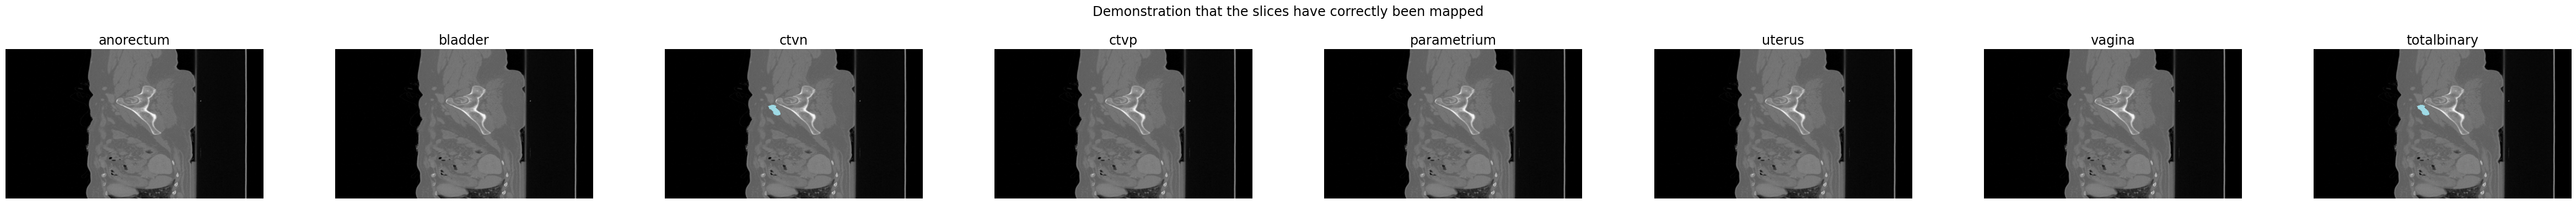

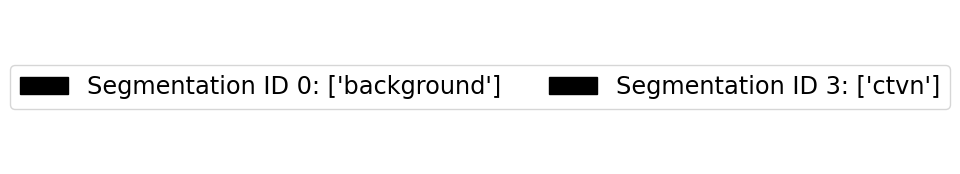

In [147]:
nrows, ncols = 1, len(gt_all)

# reshape the grid to fit the dimensions of each image
height, width = image_slice_cropped.shape
divisor = max([height, width]) / 6
height, width = height / divisor, width / divisor

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * width, nrows * height))
axes = axes.reshape(nrows, ncols)

for i in range(total_images):
    axes[0, i].imshow(image_slice_cropped, cmap='gray')
    axes[0, i].axis('off')

    alpha_mask = np.where(gt_slices_cropped[i] > 0, 1, 0).astype(np.float32)
    axes[0, i].imshow(gt_slices_cropped[i], alpha=alpha_mask, cmap=cmap, vmin=0, vmax=len(segmentation_ids) - 1)
    axes[0, i].axis('off')    

    axes[0, i].set_title(get_id_from_label(i), fontsize='xx-large')

plt.suptitle('Demonstration that the slices have correctly been mapped', y=1.05, fontsize='xx-large')
plt.tight_layout()

# Create a separate figure for the legend
legend_fig, legend_ax = plt.subplots(figsize=(8, 2))
legend_ax.axis('off')  # Hide the axis for the legend subplot

# Create legend handles and labels

legend_handles = [Patch(color=c, label=f'Segmentation ID {sid}: {reverse_lookup_id(sid)}') for sid, c in zip(segmentation_ids, colors)]
               # [Patch(color=id_to_color[sid], label=f'Segmentation ID {sid}: {reverse_lookup_id(sid)}') for sid in segmentation_ids]
legend_ax.legend(handles=legend_handles, loc='center', fontsize='xx-large', ncol=5)

plt.show()


In [148]:
for sid in segmentation_ids:
    print(f"Segmentation ID {sid}: {reverse_lookup_id(sid)} - Color: {explicit_color_mapping[sid]}")


NameError: name 'explicit_color_mapping' is not defined